# Evaluator-Optimizer con LangGraph

## Definición (nivel MIT/Stanford, aplicada)
Evaluator-Optimizer implementa mejora iterativa: genera, evalúa con criterio explícito y refina hasta aprobar umbral o agotar iteraciones.

## Cuándo usarla
Úsala cuando calidad y consistencia pesan más que latencia y costo.

## Cuándo NO usarla
Evítala en flujos en tiempo real con SLA estricto.

## Diagrama Conceptual

```mermaid
graph TD
A[Generate] --> B[Evaluate]
B -->|pass| C[Finalize]
B -->|fail| A
```

In [1]:
# Setup de clase
from __future__ import annotations

import importlib.util
import inspect
import json
import sys
from pathlib import Path
from IPython.display import Image, Markdown, display


def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "pyproject.toml").exists():
            return p
    raise RuntimeError("No se encontro raiz del repo")


def load_module(path: Path, module_name: str):
    spec = importlib.util.spec_from_file_location(module_name, path)
    module = importlib.util.module_from_spec(spec)
    if spec is None or spec.loader is None:
        raise RuntimeError(f"No se pudo cargar modulo: {path}")
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

ROOT = find_repo_root(Path.cwd())
print(f"Repo root: {ROOT}")

Repo root: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry


In [2]:
script_path = ROOT / '04_langchain_langgraph/04_evaluator_optimizer/Notebooks/01_evaluator_optimizer_langgraph.py'
module = load_module(script_path, 'nb_eval_opt')
run_fn = module.run_evaluator_optimizer
print('Script:', script_path)
print('Función:', run_fn.__name__)

Script: /Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/04_langchain_langgraph/04_evaluator_optimizer/Notebooks/01_evaluator_optimizer_langgraph.py
Función: run_evaluator_optimizer


## Código de la arquitectura (visible en notebook)

In [3]:
print(inspect.getsource(run_fn)[:5000])

def run_evaluator_optimizer(profile: dict | None = None, verbose: bool = True) -> dict:
    root = find_repo_root(Path.cwd())
    load_dotenv(root / ".env")
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        raise RuntimeError("OPENAI_API_KEY no esta definida en .env")

    model = os.getenv("OPENAI_MODEL", "gpt-4o-mini")
    llm = ChatOpenAI(model=model, temperature=0.5, api_key=api_key)

    build_context_packet = load_context_builder(root)
    if profile is None:
        profile = {
            "tipo_persona": "arquitecta apasionada por fotografia urbana",
            "gustos": ["cafes tranquilos", "jazz", "viajes cortos"],
            "estilo": "intelectual y relajado",
            "contexto": "primera interaccion tras match reciente",
        }
    context_packet = build_context_packet(profile=profile, architecture="evaluator_optimizer")

    def generate(state: EvalOptState) -> dict:
        feedback = ""
        if state.get("evaluation"):
            feedback

## Ejemplo 1: caso base del curso

In [4]:
result_1 = run_fn(verbose=False)
print('Modelo:', result_1['__model'])
print('Context hash:', result_1['__context_hash'])

Modelo: gpt-4o-mini
Context hash: 90abdaf83ffd


In [5]:
print('Salida final ejemplo 1:')
print(json.dumps(result_1['final'], ensure_ascii=False, indent=2))

Salida final ejemplo 1:
{
  "opener": "¡Hola! Me alegra que hayamos hecho match. Como arquitecta, seguro tienes una mirada única sobre la fotografía urbana. ¿Tienes algún lugar favorito en la ciudad que te inspire? Por cierto, a mí también me encantan los cafés tranquilos, son perfectos para disfrutar de una buena charla o simplemente relajarse un rato.",
  "follow_up": "Además, me encantaría saber si tienes alguna recomendación de jazz que te guste. Siempre estoy buscando nuevas melodías para acompañar mis momentos de relax, especialmente después de un viaje corto. ¿Cuál ha sido tu destino favorito últimamente?",
  "evaluation_score": 8,
  "why_it_works": [
    "La personalización es adecuada y se refiere a los intereses de la arquitecta, como la fotografía urbana y los cafés tranquilos.",
    "La naturalidad en el lenguaje es buena, creando un ambiente relajado.",
    "Se respeta el contexto y no hay lenguaje manipulativo ni presión."
  ]
}


## Grafo real LangGraph (comportamiento)

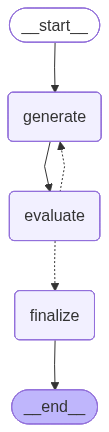

In [6]:
agent = result_1['__agent']
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as exc:
    print('No se pudo renderizar PNG en este entorno:', exc)
    display(Markdown('```mermaid\n' + result_1['__graph_mermaid'] + '\n```'))

## Ejemplo 2: asistente latino experto en enamorar (coqueteo creativo y respetuoso)

In [7]:
profile_coqueteo = {
  "tipo_persona": "asistente latino experto en enamorar con elegancia",
  "gustos": [
    "salsa romantica",
    "cafes bohemios",
    "poesia urbana",
    "paseos nocturnos"
  ],
  "estilo": "carismatico, coqueto, respetuoso, humor picante sutil",
  "contexto": "quiere iniciar una conversacion de coqueteo sin caer en frases prefabricadas"
}
result_2 = run_fn(profile=profile_coqueteo, verbose=False)
print('Context hash coqueteo:', result_2['__context_hash'])

Context hash coqueteo: 261b29345a3f


In [8]:
print('Salida final ejemplo coqueteo:')
print(json.dumps(result_2['final'], ensure_ascii=False, indent=2))

Salida final ejemplo coqueteo:
{
  "opener": "Hola, ¿cómo va tu día? Estaba pensando en lo bonito que sería disfrutar de una tarde en un café bohemio, con buena música de salsa romántica de fondo. ¿Te gusta ese tipo de ambiente?",
  "follow_up": "Además, me encantaría saber si tienes algún poema urbano favorito o si te gusta pasear por la ciudad cuando cae la noche. Esos momentos tienen su propia magia, ¿no crees?",
  "evaluation_score": 8,
  "why_it_works": [
    "La personalización es notable, ya que se mencionan dos gustos específicos: el café bohemio y la salsa romántica.",
    "La naturalidad de la conversación se mantiene, evitando frases prefabricadas.",
    "Se respeta el contexto y las restricciones, ya que no hay manipulación ni presión.",
    "Cumple con los requisitos de un buen inicio de conversación."
  ]
}


## Errores típicos en producción
- Elegir esta arquitectura por moda y no por necesidad.
- No definir métricas de calidad/costo/latencia antes de escalar.
- No versionar contexto ni criterios de evaluación.
- Falta de observabilidad para diagnosticar degradaciones.

## Lectura crítica del resultado
- Evalúa si el flujo realmente mejoró calidad o solo añadió complejidad.
- Compara latencia/costo vs beneficio de control arquitectónico.
- Decide si esta arquitectura es mínima suficiente para tu caso real.